# Introduction
In this study, we will start by studying the applicability of using the raw data from the seismometer as an input to the neural network for recognition and prediction of earthquakes. The raw data is a time series data of 100 Hz frequency which discribes the vertical motion of the earth. The figure below show a simple illustration of how it is measured. Note that the current tools rely on a more sophisticated and accurate tools but the concept is still the same.

As mentioned above, two problems are studied described in the figure above. Obviously, the second problem is more complicated as there is no known method to do this. In fact, it is not known that the signal contain information for the prediction. The two problems are:
1. The recognition of the earthquakes signal after they occur.
2. The prediction of earthquakes signal before they occur.

<img src="Figures/For Notbooks/Seismometer.png" width="700">

# Dataset
The dataset was harvested from servers specifically for this study. After compiling numerous datasets with varying [minimum earthquake magnitude](https://en.wikipedia.org/wiki/Richter_magnitude_scale), lateral coverage, and number of stations, this study area ([The Geysers](https://en.wikipedia.org/wiki/The_Geysers)) of the  is specifically chosen because:
1. It contains a spatially dense seismometers coverage.
2. The seismicmometers have been operating for a relatively long time.
3. The area is tectonically active because of the existance of the geysers.
4. Enhanced geothermal system are operating in the area creating more earthquakes.

<img src="Figures/For Notbooks/Map.png" width="600">


# Package and helper functions
We will use [Keras](https://keras.io/) to build the neural network, [Matplotlib](https://matplotlib.org/) for plotting results if needed, and [Numpy](http://www.numpy.org/) for matrix manipulation.

In [1]:
# Numpy (The God package)
import numpy as np

# MatplotLib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.colors import Normalize

# Other
import math as M
from skimage.transform import resize
from obspy.imaging.cm import obspy_sequential

# Keras
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Flatten, MaxPooling1D, MaxPooling2D
from keras.optimizers import Adam

# Sklearn
from sklearn.metrics import confusion_matrix

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We will use this cell to create some helper functions that will be used in the analysis. We decided to have all the functions needed in one script to facilitate readibility and understanding.

In [34]:
def splitDataset2D(X, Y, proportions=np.array([.8, .2])):
    """
    Splits the dataset into a number of smaller datasets with certain given ratios.
    
    Argument:
    X -- Input dataset
    Y -- Labels

    Returns:
    Xs -- Splitted dataset (dictionary with numbers as keys)
    Ys -- Splitted labels  (dictionary with numbers as keys)
    """
    
    # Make sure proportions are a numpy array
    proportions = np.array(proportions)
    
    # Handle an option to provide one ratio
    if (np.sum(proportions)!=1):
        ratios = np.concatenate((proportions, np.array([1-np.sum(proportions)])))
        
    # Create the random indices
    m = X.shape[0] 
    randomIndecies = np.random.permutation(m)
    
    # Calculate the number of boundaries of indecies in each set
    nSamples = np.round(proportions * m)
    nSamples = np.concatenate((np.array([0]), np.round(proportions * m)))
    nSamples = np.cumsum(nSamples)
    nSamples = nSamples.astype(int)
    
    # Extract teh sets
    Xs = []
    Ys = []
    for i in range(0, proportions.size):
        chosenSamples = randomIndecies[nSamples[i]:nSamples[i+1]]
        Xs.append(X[chosenSamples, :, :, :])
        Ys.append(Y[chosenSamples, :])
        
    return Xs, Ys

# ======================================================================
def normalizeData(data, axis=None, keepdims=True):
    """
    Computes the zscore of data along a certain axis.
    
    Argument:
    data -- Data to be normalized
    axis -- Axis to normalized (if no axis is given, we

    Returns:
    normalizedData -- normalized dataset
    Ys -- Splitted labels  (dictionary with numbers as keys)
    """
    
    # Zscore normalization
    normalizedData = (data - np.mean(data, axis = axis, keepdims= keepdims)) / np.std(data, axis = axis, keepdims = keepdims)
    return normalizedData

# ======================================================================
def spectrogramAnalysis(signal, fs, newShape=None, isNormalize=False, isPlot=False):
    """
    Runs the spectogram analysis, resize, and normalize in one go.
    
    Argument:
    signal      -- Data to be analyzed (1D)
    fs          -- Sampling frequency
    newSahpe    -- New size to scale histogram
    isNormalize -- Normalize the result or not
    isPlot      -- To show the results in a figure

    Returns:
    specgram -- Histogram (2D image, 1 channel)
    freq     -- Frequency vector
    time     -- Time vector
    """
    
    specgram, freq, time = getSpectrogram(signal, fs, dbscale=True)
    
    if (newShape != None):
        specgram = resize(specgram,newShape)
        
    if (isNormalize == True):
        specgram = normalizeData(specgram)
        
    if (isPlot == True):
        fig = plt.figure(num=None, figsize=(10, 8), dpi=100)
        plt.imshow(specgram)
        plt.gca().invert_yaxis()
        
    return specgram, freq, time

# ======================================================================
def plotAccuracy(history, isError=True):
    trainValues = np.array(history.history["acc"])
    validValues = np.array(history.history["val_acc"])
    
    if (isError == True):
        trainValues = 1-trainValues
        validValues = 1-validValues
    
    trainAxe, = plt.plot(trainValues, label="Training set")
    validAxe, = plt.plot(validValues, label="Validation set")
    
    if (isError == True):
        plt.ylabel('Error (fraction)')
    else:
        plt.ylabel('Accuracy (fraction)')

    plt.xlabel('Epoch')
    
    plt.legend(handles=[trainAxe, validAxe])

# ======================================================================
def getSpectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, zorder=None, title=None,
                show=True, sphinx=False, clip=[0.0, 1.0]):
    """
    Computes Spectogram of a 1D signal. This functions are based on Obspy internal functions
    """
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)
    
    return specgram, freq, time

# ======================================================================
def _nearest_pow_2(x):
    """
    Finds power of two nearest to x.

    Argument:
    x -- number
    
    Returns:
    a/b -- Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

# Dataset

Now, we will load the dataset. The dataset is already saved in binary numpy format using another script written specifically for this study. The data loaded is the time series data and the labels. Note that we have two datasets.

In [120]:
folderName = "FinalDatasets"
datasetNumber = 9
testPercent   = .1
fs = 100
spectogramShape = [128, 256]

data = np.load(folderName + "\Data_D" + str(datasetNumber) + ".npy")
label = np.load(folderName + "\Label_D" + str(datasetNumber) + ".npy")

data = data[27000:30000,:,:]

We will calculate the spectogram for each 1D signal. The spectogram images are then collected as a dataset that will be used in the analysis.

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


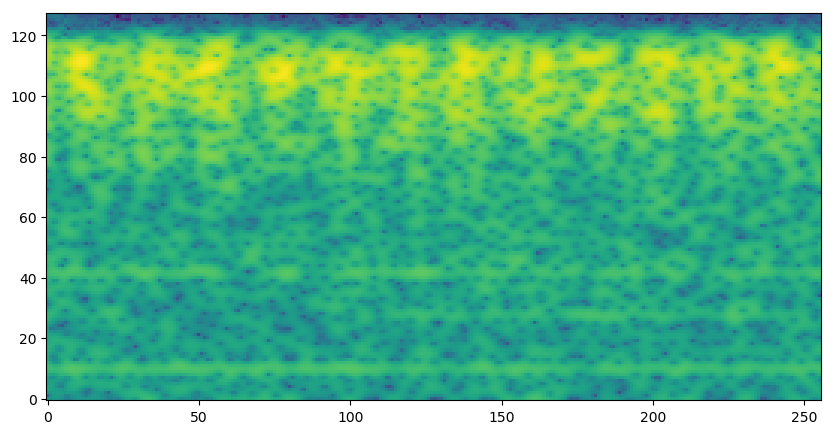

In [121]:
specgram, freq, time = spectrogramAnalysis(data[:,30,0], fs, spectogramShape, isPlot=True)

In [122]:
dataSpectrogram = np.zeros((data.shape[1], spectogramShape[0], spectogramShape[1], data.shape[2]))
for i in range(data.shape[1]):
    for k in range(data.shape[2]):
        dataToAnalyze = data[:,i,k]
        specgram, freq, time = spectrogramAnalysis(dataToAnalyze, fs, spectogramShape)
        dataSpectrogram[i,:, :,k] = specgram

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [123]:
# Calculate the training percentage
trainingPercent = 1 - testPercent;

# Split the dataset
Xs, Ys = splitDataset2D(dataSpectrogram, label, proportions=[trainingPercent, testPercent])

# Get training data
xTrain = Xs[0][:,:,:,0]
yTrain = Ys[0][:,0]

# Get test data
xTest = Xs[1][:,:,:,0]
yTest = Ys[1][:,0]

# Neural network model

The model that will be used for this 1D convolutional network is as discribed in the figure.

In [124]:
def constructModel(inputShape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    xInput = Input(shape = inputShape)
    
    X = Conv1D(filters=100,kernel_size=3,strides=1)(xInput)                          
    X = BatchNormalization()(X)                          
    X = Activation(activation='relu')(X)                              
    X = Dropout(rate=0.3)(X)                         

    X = LSTM(units=20, return_sequences=True)(X)                              
    X = Dropout(rate=.3)(X)                                 
    X = BatchNormalization()(X)                              
    
    X = LSTM(units=30, return_sequences=True)(X)
    X = Dropout(rate=0.3)(X)                                 
    X = BatchNormalization()(X)                     
    
    X = TimeDistributed(Dense(1, activation = "relu"))(X) 
    X = Flatten()(X)
    X = Dense(1, activation = "sigmoid")(X)

    model = Model(inputs = xInput, outputs = X)
    
    return model

model = constructModel(inputShape = (xTrain.shape[1], xTrain.shape[2]))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 128, 256)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 126, 100)          76900     
_________________________________________________________________
batch_normalization_88 (Batc (None, 126, 100)          400       
_________________________________________________________________
activation_30 (Activation)   (None, 126, 100)          0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 126, 100)          0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 126, 20)           9680      
_________________________________________________________________
dropout_89 (Dropout)         (None, 126, 20)           0         
__________

# Training the model

In [127]:
model = constructModel(inputShape = (xTrain.shape[1], xTrain.shape[2]))
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
history = model.fit(xTrain, yTrain, batch_size = 256, epochs=25, validation_split=.1)

Train on 309 samples, validate on 35 samples
Epoch 1/25
309/309 [==============================] - 11s 36ms/step - loss: 0.7537 - acc: 0.5081 - val_loss: 0.7386 - val_acc: 0.5429
Epoch 2/25
309/309 [==============================] - 2s 5ms/step - loss: 0.7916 - acc: 0.5307 - val_loss: 0.7748 - val_acc: 0.4857
Epoch 3/25
309/309 [==============================] - 2s 5ms/step - loss: 0.7459 - acc: 0.4951 - val_loss: 0.7687 - val_acc: 0.4857
Epoch 4/25
309/309 [==============================] - 2s 5ms/step - loss: 0.7467 - acc: 0.5307 - val_loss: 0.7589 - val_acc: 0.5143
Epoch 5/25
309/309 [==============================] - 2s 5ms/step - loss: 0.7301 - acc: 0.4984 - val_loss: 0.7647 - val_acc: 0.4000
Epoch 6/25
309/309 [==============================] - 2s 5ms/step - loss: 0.7321 - acc: 0.4984 - val_loss: 0.7645 - val_acc: 0.3714
Epoch 7/25
309/309 [==============================] - 2s 6ms/step - loss: 0.7022 - acc: 0.5502 - val_loss: 0.7479 - val_acc: 0.4286
Epoch 8/25
309/309 [=========

38/38 [==============================] - 0s 3ms/step
Test set accuracy =  0.5526315789473685
Guess Accuracy =  0.5392670157068062
[[0.39473684 0.13157895]
 [0.31578947 0.15789474]]
Test set accuracy (C) =  0.5526315789473684


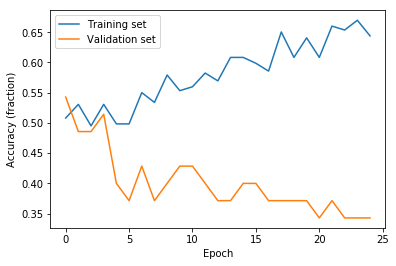

In [129]:
loss, acc = model.evaluate(xTest, yTest)
print("Test set accuracy = ", acc)
print("Guess Accuracy = ", 1-np.sum(label)/label.size)

yPred = model.predict(xTest) > .5
confusionMatrix = confusion_matrix(yTest, yPred)/yTest.size
print(confusionMatrix)
print("Test set accuracy (C) = ", confusionMatrix[0,0]+confusionMatrix[1,1])

plotAccuracy(history, False)   